# Restricted [Boltzmann Machines](http://proceedings.mlr.press/v5/salakhutdinov09a/salakhutdinov09a.pdf), Movie Reviews

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

## Load Dataset

In [2]:
movies = pd.read_csv('./datasets/ml-1m/movies.dat', sep='::', header=None, engine='python', encoding='latin-1')
users = pd.read_csv('./datasets/ml-1m/users.dat', sep='::', header=None, engine='python', encoding='latin-1')
ratings = pd.read_csv('./datasets/ml-1m/ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')

In [3]:
movies.columns = ['No.', 'Film Title', 'Genres']
movies.head()

,No.,Film Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Prepare Training & Test Set

In [4]:
train_set = pd.read_csv('./datasets/ml-100k/u1.base', delimiter='\t')
train_set = np.array(train_set, dtype='int')
test_set = pd.read_csv('./datasets/ml-100k/u1.test', delimiter='\t')
test_set = np.array(test_set, dtype='int')

## Generate Matrix

In [5]:
no_users = int(max(max(train_set[:,0]), max(test_set[:,0])))
no_movies = int(max(max(train_set[:,1]), max(test_set[:,1])))

In [6]:
def convert(data):
    new_data = []
    for id_users in range(1, no_users + 1):
        id_movies = data[:,1][data[:,0] == id_users]
        id_ratings = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(no_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    
    return new_data

In [7]:
train_set = convert(train_set)
test_set = convert(test_set)

## Convert Data Into Tensors

In [8]:
train_set = torch.FloatTensor(train_set)
test_set = torch.FloatTensor(test_set)

In [9]:
train_set[train_set == 0] = -1
train_set[train_set == 1] = 0
train_set[train_set == 2] = 0
train_set[train_set >= 3] = 1
test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1

## Create The [RBM](https://www.cs.toronto.edu/~rsalakhu/papers/rbmcf.pdf) Network Architecture

In [10]:
class RBM():
    def __init__(self, nv, nh):
        self.W = torch.randn(nh, nv)
        self.a = torch.randn(1, nh)
        self.b = torch.randn(1, nv)
        
    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    
    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    
    def train(self, v0, vk, ph0, phk):
        self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)

In [11]:
class RBMNet():
    def __init__(self, nv, nh):
        self.W = torch.randn(nh, nv)
        self.a = torch.randn(1, nh)
        self.b = torch.randn(1, nv)

    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def train(self, v0, vk, ph0, phk):
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t() # transpose
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)

In [12]:
nv = len(train_set[0])
nh = 200
batch_size = 100
rbm = RBM(nv, nh)

In [13]:
nv = len(train_set[0])
nh = 200
batch_size = 100
rbm = RBMNet(nv, nh)

## Train The RBM Network

In [14]:
nb_epoch = 10
train_loss_history = []
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(0, no_users - batch_size, batch_size):
        vk = train_set[id_user:id_user+batch_size]
        v0 = train_set[id_user:id_user+batch_size]
        ph0, _ = rbm.sample_h(v0)
        for k in range(10):
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        phk, _ = rbm.sample_h(vk)
        rbm.train(v0, vk, ph0, phk)
        train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
        s += 1.
    
    train_loss_history.append(train_loss.item())
    print('Epoch: %d, loss: %.7f' % (epoch, train_loss.item()/s))

Epoch: 1, loss: 0.3668492
Epoch: 2, loss: 0.2544441
Epoch: 3, loss: 0.2502563
Epoch: 4, loss: 0.2514656
Epoch: 5, loss: 0.2452571
Epoch: 6, loss: 0.2488963
Epoch: 7, loss: 0.2483576
Epoch: 8, loss: 0.2445155
Epoch: 9, loss: 0.2481568
Epoch: 10, loss: 0.2434866


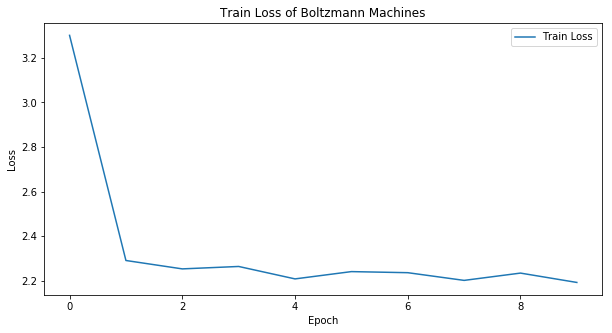

In [15]:
plt.figure(figsize=(10,5))
plt.title("Train Loss of Boltzmann Machines")
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/final_train_loss.png')
plt.show()

## Test The RBM Network

In [16]:
test_loss = 0
s = 0.
for id_user in range(no_users):
    v = train_set[id_user:id_user+1]
    vt = test_set[id_user:id_user+1]
    if len(vt[vt>=0]) > 0:
        _, h = rbm.sample_h(v)
        _, v = rbm.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        s += 1.
print('Test loss: %.7f' % (test_loss.item()/s))

Test loss: 0.2473824


---